# Praktisches Projekt: Visual Emotion Recognition

Ziel ist es, die Emotion eines Gesichts zu klassifizieren.
Diese Aufgabe ist auf Grund der hohen Abstraktionsebene bei der Erkennung sehr anspruchsvoll.


## WSCNet: Weakly Supervised Coupled Networks for Visual Sentiment Classification and Detection

Als Architektur zur Lösung des Visual Emotion Recognition Problems wird ein WSCNet (She, Dongyu and Yang, Jufeng and Cheng, Ming-Ming and Lai, Yu-Kun and Rosin, Paul L. and Wang, Liang) genutzt. Dieses besitzt folgenden Aufbau:

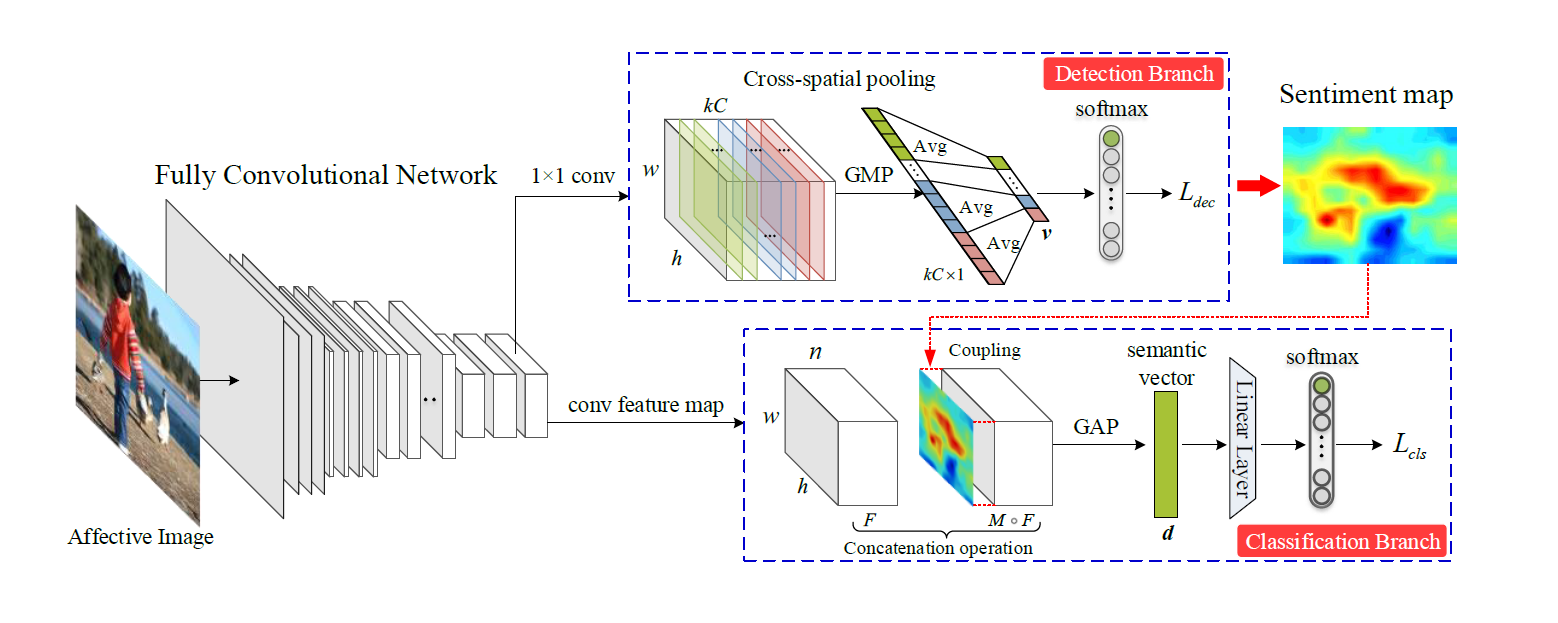

### Erkennungszweig

*   Ziel: Erzeugen einer Sentiment Map
*   Fully Convolutional Layer mit Cross-Spatial-Pooling
*   Generating Sentiment Map:

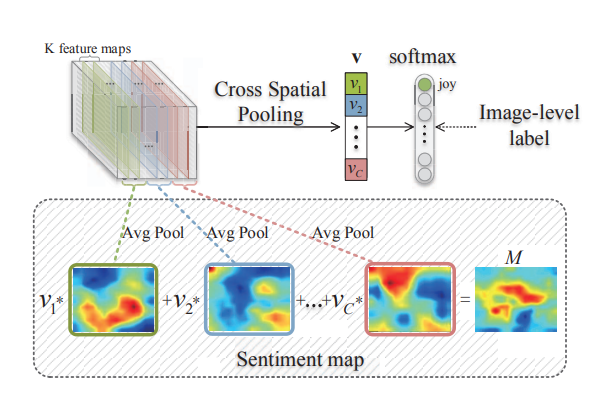

---
#### Cross-Spatial-Pooling (Raumübergreifende Pooling Strategie)

*   Gegeben sei eine Menge an $N$ Trainingsdaten $\{(x_i, y_i)\}_{i=1}^N$ mit $x_i$ als Bild, $y_i \in \{1, ..., C\}$ als dazugehöriges Label und $C$ als Anzahl der möglichen Kategorien.
*   Für jede Instanz sei $F \in \mathbb R ^{w \times h \times n} $ die Feature-Map aus dem F-CNN mit $w$ und $h$ als räumlicher Größe und $n$ als Anzahl der Channels.
*   Nach einer 1x1 Convolution wird die transformierte Feature-Map $F' \in \mathbb R ^{w \times h \times kC} $ mit $k$ als Anzahl der Feature-Maps.
*   Wir möchten nun alle relevanten Informationen als einzelnen Score zusammenfassen: $v_c = \frac{1}{k} \sum_{i=1}^k G_{max}(f_{c,i}), c \in \{1, ..., C\}$ mit $f_{c,i}$ als $i$-te Feature-Map der $c$-ten Kategorie und $G_{max}()$ als Global-Maximum-Pooling-Funktion (GAP).
*   Das GMP wir genutzt, um nur das wichtigste der erklärenden Parts einer jeden Feature-Map der gleichen Klasse im Vektor $v_c \in \mathbb R ^{1 \times 1 \times kC}$ zu erhalten.
*   Die Informationen der $k$ Feature-Maps werden nun durch Global-Average-Pooling (GAP) pro Klasse aggregiert, was den Vektor $v \in \mathbb R ^C$ erzeugt.
*   Dieser wird nun mit einer $C$-Klassen-Softmax Aktivierungsfunktion aktiviert.
* Anschließend wird die Sentiment Map $M \in \mathbb R ^{w \times h}$ mithilfe des Vektors $v_c$ gebildet.


### Kopplung und Classification Pfad

*   Kopplung: Die Feature-Map $F$ der ursprünglichen Convolution, welche die ungewichteten Informationen des gesamten Bildes enthält, wird nun mit der Sentiment-Map gekoppelt, $U_i = M \circ F_i$.
*   Semantic-Vector: Die gekoppelte Feature-Map wird mit der usprüunglichen Feature Map verkettet, um einen mit Informationen angereicherten Vektor $d$ zu erhalten, $d  = G_{avg}(F \uplus U)$ mit $G_{avg}$ als Global-Average-Pooling (GAP) Funktion
*   Nun wird standardmäßig ein Fully Connected Layer und eine Softmax-Aktivierungsfunktion zur Ausgabe der Klassifierung nachgeschaltet.



Quelle: 

*She, Dongyu & Yang, Jufeng & Cheng, Ming-Ming & Lai, Yu-Kun & Rosin, Paul & Wang, Liang. (2019). WSCNet: Weakly Supervised Coupled Networks for Visual Sentiment Classification and Detection. IEEE Transactions on Multimedia. PP. 1-1. 10.1109/TMM.2019.2939744.*

*https://openaccess.thecvf.com/content_cvpr_2018/papers/Yang_Weakly_Supervised_Coupled_CVPR_2018_paper.pdf*




### LogSoftmax


*   Es wurde statt einer Softmax eine Log Softmax Aktivierungsfunktion in beiden Branches verwendet. 
*   Im mathematischen Sinne ist das Ziel des WSCNets, die Wahrscheinlichkeit $p_i = P(X=y_i)$ der Klasse zu maximieren, welcher die Trainingsinstanz angehört.
*   Der Output der Softmax Function kann als Wahrscheinlichkeitsverteilung über die $C$ möglichen Klassen verstanden werden (*Categorical distribution*, wir erhalten $p_i$).
*   Die Log-Softmax Funktion führt dazu, dass wir $\log p_i$ maximieren, was in weniger Optimierungsschritten ein Optimum erreicht.
*   Die Log-Softmax Funktion ist numerisch stabiler und lässt sich in der Backpropagation schneller berechnen als die Softmax-Funktion (-> Computational Performance) und bietet eine schnelle Optimierung, insb. in Verbindung mit der NLL-Loss Funktion (Negativ-Log-Likelihood).

Beispiel:


Wir betrachten den Output des Forward-Steps eines Deep-Neural-Networks $p(\mathbf{x})$ und den dazugehörigen Gradienten für die Backpropagation $\frac{\partial \; p(\mathbf{x})}{\partial \; \mathbf{x}}$ mit der bekannten Wahrscheinlichkeitsfunktion $p(\mathbf{x}) = p(x) = \exp(-x^2)$ 




Vergleichen wir den Output der Softmax-Aktivierungsfunktion, eben $s(x) = p(x)$, mit dem Output der Log-Softmax-Aktivierungsfunktion $l(x) = \log p(x) = -x^2$.

\\
Softmax:  $\frac{d \; s(x)}{d \; x} = -2x \cdot \exp(-2x^2)$
*  Schlechte globale Eigenschaften für die Optimierung (-> Exploding Gradient)

\\
Log-Softmax: $\frac{d \; l(x)}{d \; x} = -2x$
*  Gute globale Konvergenzeigenschaften

Quellen: 

*Paul (https://stats.stackexchange.com/users/11646/paul), Why to optimize max log probability instead of probability, URL (version: 2015-10-13): https://stats.stackexchange.com/q/176563*

*shimao (https://stats.stackexchange.com/users/26948/shimao), Log probabilities in reference to softmax classifier, URL (version: 2017-07-08): https://stats.stackexchange.com/q/289447*



## Trainingsprozess des WSCNet

### Initialisierung der Python Umgebung und Laden der Trainingsdaten

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun 22 19:46:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cd /content/drive/MyDrive/Seminar_CV
#!cd /conent/dataset/
#!unzip "/content/drive/MyDrive/Seminar_CV/fer2013.zip" -d "/content/drive/MyDrive/Seminar_CV/"
!unzip "/content/drive/MyDrive/Seminar_CV/fer2013.zip" -d "/content/"

# Kann weng:
#!git clone https://github.com/sherleens/WSCNet.git

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: /content/fer2013/train/Surprise/2582.jpg  
  inflating: /content/fer2013/train/Surprise/2583.jpg  
  inflating: /content/fer2013/train/Surprise/2584.jpg  
  inflating: /content/fer2013/train/Surprise/2585.jpg  
  inflating: /content/fer2013/train/Surprise/2586.jpg  
  inflating: /content/fer2013/train/Surprise/2587.jpg  
  inflating: /content/fer2013/train/Surprise/2588.jpg  
  inflating: /content/fer2013/train/Surprise/2589.jpg  
  inflating: /content/fer2013/train/Surprise/259.jpg  
  inflating: /content/fer2013/train/Surprise/2590.jpg  
  inflating: /content/fer2013/train/Surprise/2591.jpg  
  inflating: /content/fer2013/train/Surprise/2592.jpg  
  inflating: /content/fer2013/train/Surprise/2593.jpg  
  inflating: /content/fer2013/train/Surprise/2594.jpg  
  inflating: /content/fer2013/train/Surprise/2595.jpg  
  inflating: /content/fer2013/train/Surprise/2596.jpg  
  inflating: /content/fer2013/train/Su

In [2]:
#!pip uninstall torch
#!pip uninstall torchvision
!pip install torch==1.0.0
!pip install torchvision==0.2.2


from __future__ import print_function 
from __future__ import division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import time
import os
import copy

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 591.8 MB 664 bytes/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.0.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.0.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.0.0 which is incompatible.
fastai 2.6.3 requires torch<1.12,>=1.7.0, but you have torch 1.0.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████

In [ ]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.0.0
Torchvision Version:  0.2.2


### Initialisieren des WSCNet

In [4]:
#Quelle!
data_dir = '/content/fer2013'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 7

# Number of feature map in each class
num_maps = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 6 #16

# Number of epochs to train for 
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

model_savepath = '/content/drive/MyDrive/Seminar_CV/models'

In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_corrects_dec = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                        
                    else:
                        outputs1, outputs2 = model(inputs)
                        loss1 = criterion(outputs1, labels)
                        loss2 = criterion(outputs2, labels)
                        loss = 0.5*loss1 + 0.5*loss2
                        

                    _, preds = torch.max(outputs2, 1)
                    _, preds_dec = torch.max(outputs1, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        lr = optimizer.param_groups[0]['lr']

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_corrects_dec += torch.sum(preds_dec == labels.data)
                
            if phase == 'train':
                scheduler_ft.step() #scheduler_ft.step(loss)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_acc_dec = running_corrects_dec.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f} Dec: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_acc_dec))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val':
                #writer.add_scalar('epoch_valloss', epoch_loss, global_step = epoch)
                #writer.add_scalar('epoch_valacc', epoch_acc, global_step = epoch)
                val_acc_history.append(epoch_acc)
            #else:
                #writer.add_scalar('epoch_trainloss', epoch_loss, global_step = epoch)
                #writer.add_scalar('epoch_traincc', epoch_acc, global_step = epoch)
                #writer.add_scalar('lr_train', lr, global_step = epoch)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [9]:
class ResNetWSL(nn.Module):
    
    def __init__(self, model, num_classes, num_maps, pooling, pooling2):
        super(ResNetWSL, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-2])
        self.num_ftrs = model.fc.in_features

        self.downconv = nn.Sequential(
            nn.Conv2d(2048, num_classes*num_maps, kernel_size=1, stride=1, padding=0, bias=True))
        
        self.GAP = nn.AvgPool2d(14)
        self.GMP = nn.MaxPool2d(14)
        self.spatial_pooling = pooling
        self.spatial_pooling2 = pooling2
        self.classifier = nn.Sequential(
            nn.Linear(4096, num_classes)
            )
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.features(x)
        x_ori = x  

        # detect branch
        x = self.downconv(x) 
        x_conv = x              
        x = self.GAP(x)  #x = self.GMP(x)       
        x = self.spatial_pooling(x) 
        x = x.view(x.size(0), -1)
        x = self.softmax(x)

        # cls branch
        x_conv = self.spatial_pooling(x_conv) 
        x_conv = x_conv * x.view(x.size(0),x.size(1),1,1) #Coupling
        x_conv = self.spatial_pooling2(x_conv) 
        x_conv_copy = x_conv
        for num in range(0,2047):            
            x_conv_copy = torch.cat((x_conv_copy, x_conv),1) 
        x_conv_copy = torch.mul(x_conv_copy,x_ori)
        x_conv_copy = torch.cat((x_ori,x_conv_copy),1) 
        x_conv_copy = self.GAP(x_conv_copy)
        x_conv_copy = x_conv_copy.view(x_conv_copy.size(0),-1)
        x_conv_copy = self.classifier(x_conv_copy)
        x_conv_copy = self.softmax(x_conv_copy)
        return x, x_conv_copy

In [10]:
from torch.autograd import Function, Variable
class ClassWisePoolFunction(Function):
    def __init__(self, num_maps):
        super(ClassWisePoolFunction, self).__init__()
        self.num_maps = num_maps

    def forward(self, input):
        # batch dimension
        batch_size, num_channels, h, w = input.size()

        if num_channels % self.num_maps != 0:
            print('Error in ClassWisePoolFunction. The number of channels has to be a multiple of the number of maps per class')
            sys.exit(-1)

        num_outputs = int(num_channels / self.num_maps)
        x = input.view(batch_size, num_outputs, self.num_maps, h, w)
        output = torch.sum(x, 2)
        self.save_for_backward(input)
        return output.view(batch_size, num_outputs, h, w) / self.num_maps

    def backward(self, grad_output):
        input, = self.saved_tensors
        # batch dimension
        batch_size, num_channels, h, w = input.size()
        num_outputs = grad_output.size(1)

        grad_input = grad_output.view(batch_size, num_outputs, 1, h, w).expand(batch_size, num_outputs, self.num_maps,
                                                                               h, w).contiguous()
        return grad_input.view(batch_size, num_channels, h, w)

class ClassWisePool(nn.Module):
    def __init__(self, num_maps):
        super(ClassWisePool, self).__init__()
        self.num_maps = num_maps

    def forward(self, input):
        return ClassWisePoolFunction(self.num_maps)(input)

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, num_maps, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    
    if model_name == "resnet":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)

        pooling = nn.Sequential()
        pooling.add_module('class_wise', ClassWisePool(num_maps))
        pooling2 = nn.Sequential()
        pooling2.add_module('class_wise', ClassWisePool(num_classes))
        model_ft = ResNetWSL(model_ft, num_classes, num_maps, pooling, pooling2)
        
        input_size = 448

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, num_maps, feature_extract, use_pretrained=True) #Test

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:02<00:00, 76030874.68it/s]


ResNetWSL(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, ke

In [12]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=64) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
print(class_names)

#image_datasets

Initializing Datasets and Dataloaders...
['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using GPU ", device)   
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()

if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)
scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using GPU  cuda:0


In [14]:
from torchsummary import summary
summary(model_ft, (3, 448, 448), 6)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [6, 64, 224, 224]           9,408
       BatchNorm2d-2          [6, 64, 224, 224]             128
              ReLU-3          [6, 64, 224, 224]               0
         MaxPool2d-4          [6, 64, 112, 112]               0
            Conv2d-5          [6, 64, 112, 112]           4,096
       BatchNorm2d-6          [6, 64, 112, 112]             128
              ReLU-7          [6, 64, 112, 112]               0
            Conv2d-8          [6, 64, 112, 112]          36,864
       BatchNorm2d-9          [6, 64, 112, 112]             128
             ReLU-10          [6, 64, 112, 112]               0
           Conv2d-11         [6, 256, 112, 112]          16,384
      BatchNorm2d-12         [6, 256, 112, 112]             512
           Conv2d-13         [6, 256, 112, 112]          16,384
      BatchNorm2d-14         [6, 256, 1

### Training

In [43]:
saved = torch.load('/content/drive/MyDrive/Seminar_CV/modelswscnet_softmax_added_20epochs.pt')

In [44]:
model_ft.load_state_dict(saved['model_state_dict'])
optimizer_ft.load_state_dict(saved['optimizer_state_dict'])

#optimizer_nadam = torch.optim.Adam(model_ft.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
# Setup the loss fxn
criterion = nn.NLLLoss()

# Train and evaluate  
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [ ]:
torch.save({
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            }, model_savepath + 'modelswscnet_softmax_added_20epochs.pt')

In [ ]:
!pip freeze --local > /content/drive/MyDrive/Seminar_CV/colab_installed.txt

In [ ]:
torch.save(model_ft, '/content/drive/MyDrive/Seminar_CV/wscnet_softmax_added_10epochs_full.pt')

In [ ]:
torch.cuda.empty_cache()

### Stats

In [ ]:
import matplotlib.pyplot as plt
b = torch.Tensor(5, 1, 1)
hist_tens = torch.tensor(hist, device = 'cpu')
arr = hist_tens.numpy()
np.savetxt('/content/drive/MyDrive/Seminar_CV/20_epochs_hist.txt', arr)

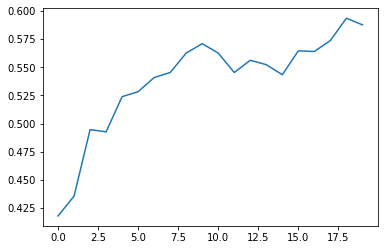

In [ ]:
history_total = np.array([4.179437169127890872e-01, 
                         4.354973530231262546e-01, 
                         4.945667316801337643e-01,
                         4.926163276678741099e-01,
                         5.238227918640290248e-01,
                         5.282808581777654888e-01,
                         5.408191696851490926e-01,
                         5.452772359988855566e-01,
                         5.625522429646141465e-01,
                         5.709111173028699193e-01,
                         5.625522429646141465e-01,
                         5.452772359988855566e-01,
                         5.561437726386180280e-01,
                         5.522429646140987192e-01,
                         5.433268319866257912e-01,
                         5.645026469768738009e-01,
                         5.639453886876567568e-01,
                         5.736974087489551399e-01,
                         5.934800780161605394e-01,
                         5.876288659793814650e-01])

plt.plot(history_total)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

model = model_ft
y_pred_dec = []
y_pred_cls = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders_dict['val']:
        output_dec, output_cls = model(inputs.to(device)) # Feed Network

        output_d = (torch.max(torch.exp(output_dec), 1)[1]).data.cpu().numpy()
        y_pred_dec.extend(output_d) # Save Prediction

        output_c = (torch.max(torch.exp(output_cls), 1)[1]).data.cpu().numpy()
        y_pred_cls.extend(output_c) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


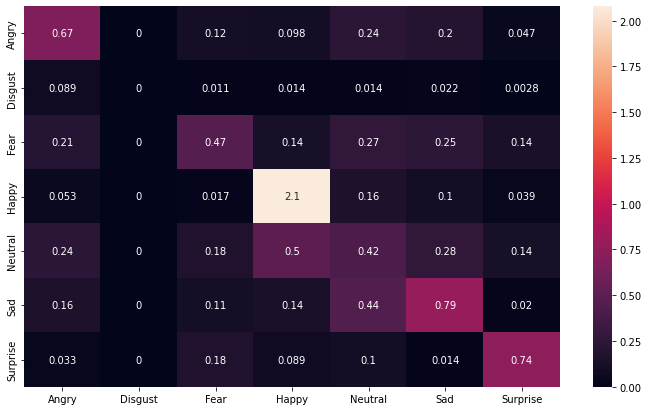

In [21]:
# Build confusion matrix 1
cf_matrix_dec = confusion_matrix(y_true, y_pred_dec)
df_cm_dec = pd.DataFrame(cf_matrix_dec/np.sum(cf_matrix_dec) *10, index = [i for i in class_names],
                     columns = [i for i in class_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm_dec, annot=True)
plt.savefig('conf_mat_dec.png')

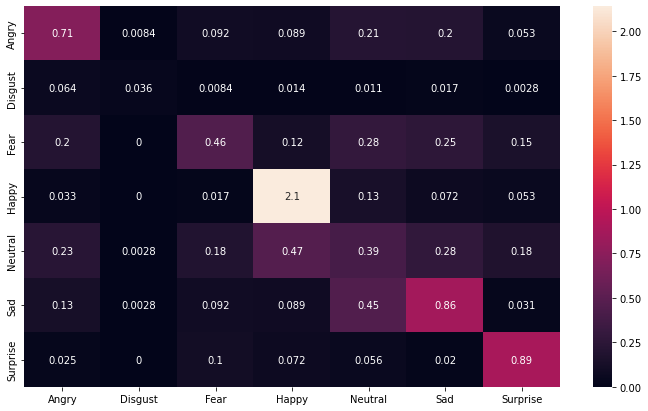

In [19]:
# Build confusion matrix 2
cf_matrix_cls = confusion_matrix(y_true, y_pred_cls)
df_cm_cls = pd.DataFrame(cf_matrix_cls/np.sum(cf_matrix_cls) *10, index = [i for i in class_names],
                     columns = [i for i in class_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm_cls, annot=True)
plt.savefig('conf_mat_cls.png')

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_dec, target_names = class_names, zero_division=0))


              precision    recall  f1-score   support

       Angry       0.46      0.49      0.48       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.43      0.32      0.37       528
       Happy       0.68      0.85      0.76       879
     Neutral       0.25      0.24      0.25       626
         Sad       0.48      0.47      0.48       594
    Surprise       0.66      0.64      0.65       416

    accuracy                           0.52      3589
   macro avg       0.42      0.43      0.42      3589
weighted avg       0.49      0.52      0.50      3589



In [33]:
print(classification_report(y_true, y_pred_cls, target_names = class_names))

              precision    recall  f1-score   support

       Angry       0.51      0.52      0.52       491
     Disgust       0.72      0.24      0.36        55
        Fear       0.48      0.31      0.38       528
       Happy       0.71      0.87      0.79       879
     Neutral       0.25      0.23      0.24       626
         Sad       0.51      0.52      0.51       594
    Surprise       0.65      0.76      0.70       416

    accuracy                           0.55      3589
   macro avg       0.55      0.49      0.50      3589
weighted avg       0.53      0.55      0.53      3589

